In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path as p
from pathlib import Path
import cv2 as cv
from tqdm import tqdm
from glob import glob

from scipy.stats import spearmanr, ttest_ind, tukey_hsd, f_oneway

In [349]:
def make_t_tests(df):
    def get_p(scores_1, scores_2):
        t, p = ttest_ind(scores_1, scores_2, equal_var=False, permutations=10000)
        return p
    
    def get_significance(p, correction):
        thresholds = [0.05, 0.01, 0.001]
        for i, threshold in enumerate(thresholds):
            if p < threshold * correction:
                return '*' * (i + 1)
        return ''

    columns = ['dsc', 'hd', 'assd']

    print('---- descriptives + ANOVA ----')
    print(f'Skin Type & N & DSC & HD & ASSD \\\\')
    rows = ['Light', 'Medium', 'Dark', 'ANOVA']
    dsc_scores = [df['dsc'][df['nn_skin_type'] == 12], df['dsc'][df['nn_skin_type'] == 34], df['dsc'][df['nn_skin_type'] == 56]]
    hd_scores = [df['hd'][df['nn_skin_type'] == 12], df['hd'][df['nn_skin_type'] == 34], df['hd'][df['nn_skin_type'] == 56]]
    assd_scores = [df['assd'][df['nn_skin_type'] == 12], df['assd'][df['nn_skin_type'] == 34], df['assd'][df['nn_skin_type'] == 56]]

    for i, row in enumerate(rows[:-1]):
        print(f'{row} & {len(dsc_scores[i])} & {dsc_scores[i].mean():.3f} $\pm$ {dsc_scores[i].std():.3f} & {hd_scores[i].mean():.3f} $\pm$ {hd_scores[i].std():.3f} & {assd_scores[i].mean():.3f} $\pm$ {assd_scores[i].std():.3f} \\\\')


    anovas = []
    dsc_scores_log = [np.log(dsc_scores[0]), np.log(dsc_scores[1]), np.log(dsc_scores[2])]
    hd_scores_log = [np.log(hd_scores[0]), np.log(hd_scores[1]), np.log(hd_scores[2])]
    assd_scores_log = [np.log(assd_scores[0]), np.log(assd_scores[1]), np.log(assd_scores[2])]
    column_scores = [dsc_scores_log, hd_scores_log, assd_scores_log]

    for i, column_name in enumerate(columns):
        scores_dark = column_scores[i][2]
        scores_medium = column_scores[i][1]
        scores_light = column_scores[i][0]
        anova = f_oneway(scores_dark, scores_medium, scores_light)
        anovas.append(anova)

    print(f'ANOVA & - & F = {anovas[0][0]:.3f}, p = {anovas[0][1]:.3f} & F = {anovas[1][0]:.3f}, p = {anovas[1][1]:.3f} & F = {anovas[2][0]:.3f}, p = {anovas[2][1]:.3f} \\\\')


    print('---- Tukeys ----')
    rows_1 = ['Light', 'Medium', 'Dark']
    rows_2 = [['Dark', 'Medium'], ['Dark'], []]

    print(f'Skin Types & Statistic & p & 95\% CI \\\\')
    for i, column_name in enumerate(columns):
        print(f'    {column_name} ----')
        scores_dark = column_scores[i][2]
        scores_medium = column_scores[i][1]
        scores_light = column_scores[i][0]

        tukey = tukey_hsd(scores_light, scores_medium, scores_dark)
        tukey_ci = tukey.confidence_interval(0.95)
        
        for i, row in enumerate(rows_1):
            for j, row_2 in enumerate(rows_2[i]):
                def get_group_idx(row_name):
                    if row_name == 'Light':
                        return 0
                    elif row_name == 'Medium':
                        return 1
                    elif row_name == 'Dark':
                        return 2
                
                idx_1 = get_group_idx(row)
                idx_2 = get_group_idx(row_2)
                statistic = tukey.statistic[idx_1][idx_2]
                p = tukey.pvalue[idx_1][idx_2]
                ci_low = tukey_ci.low[idx_1][idx_2]
                ci_high = tukey_ci.high[idx_1][idx_2]
                print(f'{row} vs {row_2} & {statistic:.3f} & {p:.3f} & [{ci_low:.3f}, {ci_high:.3f}] \\\\')

def test_column_vs_predicted_skin_type(df, column_name, right_skew=True):
    # get per-fold class probabilities
    c2s = df[['f0_c2', 'f1_c2', 'f2_c2', 'f3_c2']].mean(axis=1)
    c1s = df[['f0_c1', 'f1_c1', 'f2_c1', 'f3_c1']].mean(axis=1)
    c0s = df[['f0_c0', 'f1_c0', 'f2_c0', 'f3_c0']].mean(axis=1)

    r2, p2 = spearmanr(c2s, df[column_name])
    r1, p1 = spearmanr(c1s, df[column_name])
    r0, p0 = spearmanr(c0s, df[column_name])
    r_ita, p_ita = spearmanr(df['ita_angle'], df[column_name])

    return r2, p2, r1, p1, r0, p0, r_ita, p_ita

def make_corr(df):
    column_names = ['dsc', 'hd', 'assd']
    rp2s = []
    rp1s = []
    rp0s = []
    rp_ita = []
    for column_name in column_names:
        r2, p2, r1, p1, r0, p0, r_ita, p_ita = test_column_vs_predicted_skin_type(df, column_name)
        rp2s.append((r2, p2))
        rp1s.append((r1, p1))
        rp0s.append((r0, p0))
        rp_ita.append((r_ita, p_ita))

    print('---- Correlations ----')

    print(f'Attribute & DSC & HD & ASSD \\\\')
    print(f'p(skin type = 56) & {rp2s[0][0]:.3f} & {rp2s[1][0]:.3f} & {rp2s[2][0]:.3f} \\\\')
    print(f'p(skin type = 45) & {rp1s[0][0]:.3f} & {rp1s[1][0]:.3f} & {rp1s[2][0]:.3f} \\\\')
    print(f'p(skin type = 12) & {rp0s[0][0]:.3f} & {rp0s[1][0]:.3f} & {rp0s[2][0]:.3f} \\\\')
    print(f'Predicted ITA & {rp_ita[0][0]:.3f} & {rp_ita[1][0]:.3f} & {rp_ita[2][0]:.3f} \\\\')


In [350]:
datasets = ['dermis', 'dermquest', 'isic']

def get_df(out_of_sample=True):
    if out_of_sample:
        # if stratified_sampling:
        #     prediction_files = [f'predictions/dermis_unet_strat/metrics_seg_dermquest.csv', f'predictions/dermquest_unet_strat/metrics_seg_dermis.csv']
        # else:
        #     prediction_files = [f'predictions/dermis_unet/metrics_seg_dermquest.csv', f'predictions/dermquest_unet/metrics_seg_dermis.csv']

        prediction_files = ["./predictions/ph2_dermofit_unet/metrics_['seg_dermis', 'seg_dermquest'].csv",
                            "./predictions/waterloo_ph2_unet/metrics_seg_dermofit.csv",
                            "./predictions/waterloo_dermofit_unet/metrics_seg_ph2.csv"]

        prediction_dfs = [pd.read_csv(f) for f in prediction_files]
        skin_color_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermquest', 'dermis']]
        skin_color_dfs = [pd.concat(skin_color_dfs)]
        skin_color_dfs += [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermofit', 'ph2']]
        dataset_names = ['waterloo', 'dermofit', 'ph2']
    else:
        prediction_files = ["./predictions/all_data_unet/metrics_['seg_dermquest', 'seg_dermis', 'seg_ph2', 'seg_dermofit'].csv"]
        prediction_dfs = [pd.read_csv(f) for f in prediction_files]

        skin_color_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermquest', 'dermis', 'ph2', 'dermofit']]
        skin_color_dfs = [pd.concat(skin_color_dfs)]
        dataset_names = ['all_data']

        # prediction_dfs = [pd.read_csv(f'predictions/{dataset}_unet/metrics_seg_{dataset}.csv') for dataset in datasets]
        # skin_color_dfs = [pd.read_csv(f'data/{dataset}/skin_color_prediction.csv') for dataset in datasets]
        # dataset_names = datasets

    dataset_dfs = []

    for (pred_df, skin_df, name) in zip(prediction_dfs, skin_color_dfs, dataset_names):
        skin_df.rename(columns={'file_name': 'subject'}, inplace=True)
        df_merged = pd.merge(pred_df, skin_df, on='subject')
        df_merged['dataset'] = name
        dataset_dfs.append(df_merged)

    df = pd.concat(dataset_dfs)
    return df

def get_file_name_for_row(row):
    folder = f'data'
    file_name = glob(folder + f'/**/*/{row["subject"]}.jpg', recursive=True)[0]
    return file_name

In [351]:
df_oos = get_df(out_of_sample=True)
make_t_tests(df_oos)
make_corr(df_oos)

---- descriptives + ANOVA ----
Skin Type & N & DSC & HD & ASSD \\
Light & 1587 & 0.824 $\pm$ 0.164 & 33.253 $\pm$ 25.197 & 10.757 $\pm$ 10.714 \\
Medium & 166 & 0.765 $\pm$ 0.199 & 34.804 $\pm$ 28.409 & 12.141 $\pm$ 12.168 \\
Dark & 5 & 0.522 $\pm$ 0.238 & 65.407 $\pm$ 28.891 & 26.331 $\pm$ 11.694 \\
ANOVA & - & F = 14.334, p = 0.000 & F = 3.144, p = 0.043 & F = 5.033, p = 0.007 \\
---- Tukeys ----
Skin Types & Statistic & p & 95\% CI \\
    dsc ----
Light vs Dark & 0.531 & 0.000 & [0.215, 0.848] \\
Light vs Medium & 0.091 & 0.001 & [0.033, 0.149] \\
Medium vs Dark & 0.440 & 0.004 & [0.119, 0.761] \\
    hd ----
Light vs Dark & -0.886 & 0.033 & [-1.717, -0.055] \\
Light vs Medium & 0.008 & 0.992 & [-0.143, 0.159] \\
Medium vs Dark & -0.894 & 0.034 & [-1.736, -0.052] \\
    assd ----
Light vs Dark & -1.244 & 0.008 & [-2.221, -0.268] \\
Light vs Medium & -0.085 & 0.504 & [-0.263, 0.093] \\
Medium vs Dark & -1.160 & 0.017 & [-2.150, -0.170] \\
---- Correlations ----
Attribute & DSC & HD &

In [352]:
df_is = get_df(out_of_sample=False)
make_t_tests(df_is)
make_corr(df_is)

---- descriptives + ANOVA ----
Skin Type & N & DSC & HD & ASSD \\
Light & 1587 & 0.904 $\pm$ 0.090 & 22.463 $\pm$ 17.739 & 6.208 $\pm$ 6.570 \\
Medium & 166 & 0.878 $\pm$ 0.117 & 22.062 $\pm$ 19.756 & 6.467 $\pm$ 7.272 \\
Dark & 5 & 0.734 $\pm$ 0.381 & 45.094 $\pm$ 58.989 & 19.954 $\pm$ 31.935 \\
ANOVA & - & F = 38.145, p = 0.000 & F = 2.934, p = 0.053 & F = 2.381, p = 0.093 \\
---- Tukeys ----
Skin Types & Statistic & p & 95\% CI \\
    dsc ----
Light vs Dark & 0.553 & 0.000 & [0.397, 0.709] \\
Light vs Medium & 0.034 & 0.014 & [0.006, 0.062] \\
Medium vs Dark & 0.519 & 0.000 & [0.361, 0.677] \\
    hd ----
Light vs Dark & -0.492 & 0.356 & [-1.332, 0.349] \\
Light vs Medium & 0.129 & 0.119 & [-0.024, 0.282] \\
Medium vs Dark & -0.620 & 0.202 & [-1.472, 0.231] \\
    assd ----
Light vs Dark & -0.780 & 0.123 & [-1.716, 0.155] \\
Light vs Medium & 0.068 & 0.620 & [-0.103, 0.238] \\
Medium vs Dark & -0.848 & 0.090 & [-1.796, 0.100] \\
---- Correlations ----
Attribute & DSC & HD & ASSD \\


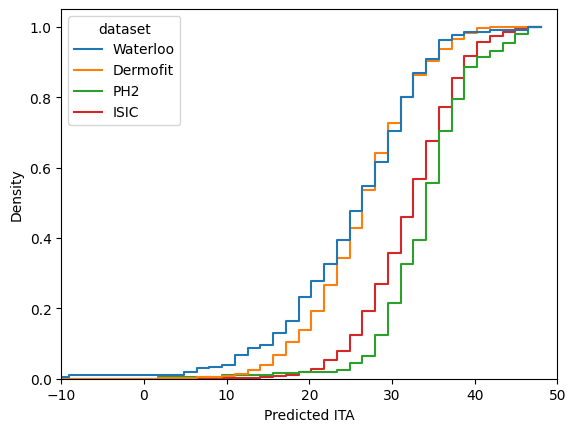

<Axes: xlabel='log(p(skin color = 56))', ylabel='Density'>

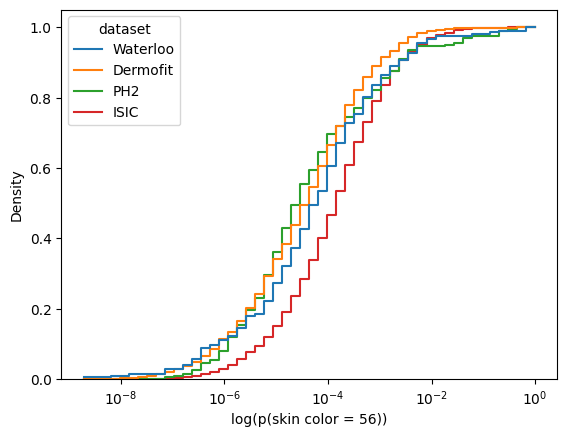

In [463]:
# plot ita angle for each dataset

dataset_names = ['dermis', 'dermquest', 'dermofit', 'ph2', 'isic']
skin_type_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in dataset_names]
for df, name in zip(skin_type_dfs, dataset_names):
    if name == 'dermis' or name == 'dermquest':
        name = 'Waterloo'
    if name == 'dermofit':
        name = 'Dermofit'
    if name == 'ph2':
        name = 'PH2'
    if name == 'isic':
        name = 'ISIC'
    df['dataset'] = name
skin_type_df = pd.concat(skin_type_dfs)

skin_type_df.rename(columns={
    'ita_angle': 'Predicted ITA',
    'f0_c2': 'log(p(skin color = 56))',
}, inplace=True)
sns.histplot(data=skin_type_df, x='Predicted ITA', hue='dataset', bins=50, common_norm=False, stat='density', cumulative=True, element='step', fill=False)
plt.xlim(-10, 50)
plt.show()

sns.histplot(data=skin_type_df, x='log(p(skin color = 56))', hue='dataset', bins=50, log_scale=True, common_norm=False, stat='density', cumulative=True, element='step', fill=False)

''

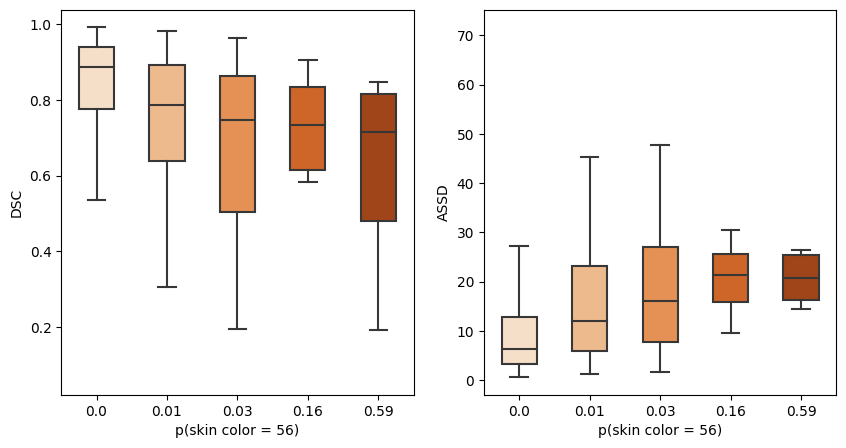

In [458]:
df = df_oos
c2s = df[['f0_c2', 'f1_c2', 'f2_c2', 'f3_c2']].mean(axis=1)
c1s = df[['f0_c1', 'f1_c1', 'f2_c1', 'f3_c1']].mean(axis=1)
c0s = df[['f0_c0', 'f1_c0', 'f2_c0', 'f3_c0']].mean(axis=1)

df_plot = df.copy()
# binned
df_plot['c2s'] = c2s
df_plot['p_bin'] = pd.cut(np.log(c2s), bins=10, labels=False)
bin_means = df_plot.groupby('p_bin')['c2s'].mean()
df_plot['p_bin'] = df_plot['p_bin'].apply(lambda x: bin_means[x].round(2))

df_plot['ita'] = pd.cut(df['ita_angle'], bins=4, labels=False)
bin_means = df_plot.groupby('ita')['ita_angle'].mean()
df_plot['ita'] = df_plot['ita'].apply(lambda x: bin_means[x].round(0))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

sns.boxplot(data=df_plot, x='p_bin', y='dsc', palette='Oranges', fliersize=0, width=0.5, ax=axs[0])
axs[0].set_xlabel('p(skin color = 56)')
axs[0].set_ylabel('DSC')

sns.boxplot(data=df_plot, x='p_bin', y='assd', palette='Oranges', fliersize=0, width=0.5, ax=axs[1])
axs[1].set_xlabel('p(skin color = 56)')
axs[1].set_ylabel('ASSD')
''

In [470]:
def manual_ttest(df):
    files_56_manual = ['isic_56_manual.txt', 'dermis_56_manual.txt', 'dermquest_56_manual.txt', 'dermofit_56_manual.txt', 'ph2_56_manual.txt']
    names_56_manual = []
    for file in files_56_manual:
        with open('data/' + file, 'r') as f:
            names_56_manual += f.read().splitlines()

    names_56_manual = [n.replace('.jpg', '') for n in names_56_manual]
    metrics_56 = df[df['subject'].isin(names_56_manual)]
    metrics_rest = df[~df['subject'].isin(names_56_manual)]

    print('56 vs rest')
    print('56', metrics_56['dsc'].mean(), metrics_56['dsc'].std(), len(metrics_56))
    print('rest', metrics_rest['dsc'].mean(), metrics_rest['dsc'].std(), len(metrics_rest))
    print(ttest_ind(np.log(1 - metrics_56['dsc']), np.log(1 - metrics_rest['dsc']), equal_var=False, permutations=10000, alternative='greater'))

print('out of sample')
manual_ttest(df_oos)

print('in sample')
manual_ttest(df_is)

out of sample
56 vs rest
56 0.6569876794625854 0.2717002876506233 23
rest 0.8198808529693995 0.16697941029641422 1735
Ttest_indResult(statistic=3.4262586840029723, pvalue=0.0015)
in sample
56 vs rest
56 0.8396236457836753 0.22863398666966175 23
rest 0.9014132396081326 0.09239887196558372 1735
Ttest_indResult(statistic=1.2090211042390608, pvalue=0.1147)
